# English to Hind translator 

In [1]:
! pip install sacrebleu evaluate rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=905f5e482ba75830561ee7323fbbea17f59cf4b4c898ea9ef4129deef02e1074
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 

## Important Libraries 

In [2]:
import numpy as np
from datasets import Dataset
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
from rouge_score import rouge_scorer
import unicodedata
import re
import nltk
import tensorflow as tf
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainerCallback,
    EarlyStoppingCallback
)


2025-05-02 22:10:23.618594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746223823.826048      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746223823.883788      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Read and undunderstand the Data 

In [3]:
df = pd.read_parquet("hf://datasets/damerajee/english-to-hindi-l/data/train-00000-of-00001.parquet")

In [4]:
df.head()

,english_sentence,hindi_sentence
0,When it is said to him: 'Fear Allah' egotism t...,"और जब उससे कहा जाता है, ""अल्लाह से डर"", तो अहं..."
1,This profile exists already.,यह प्रोफ़ाइल पहले से ही है.
2,Halo with Ornamental Borde,विवरण: एक पारंपरिक कमल के फूल के साथ पत्थर की ...
3,and the jinn We had created before from flamin...,और हम ही ने जिन्नात को आदमी से (भी) पहले वे धु...
4,"Ladies and Gentlemen, the Government of India ...",शहरीकरण की तेज गति के साथ अवसंरचना और सेवाओं क...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786788 entries, 0 to 1786787
Data columns (total 2 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   english_sentence  object
 1   hindi_sentence    object
dtypes: object(2)
memory usage: 27.3+ MB


In [6]:
df.isnull().sum()

english_sentence    0
hindi_sentence      0
dtype: int64

In [7]:
df.duplicated().sum()

238016

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
len(df)

1548772

## Preprocessing data

In [10]:
def clean(text: str) -> str:
    text = unicodedata.normalize("NFKC", text)

    text = ''.join(c for c in text if unicodedata.category(c)[0] != 'C')

    text = re.sub(r'\d+', '', text)

    # Keep English, Hindi (Devanagari block), basic punctuation, and whitespace
    text = re.sub(r'[^\w\s\u0900-\u097F.,!?;:]', '', text)

    text = re.sub(r'\s+', ' ', text)

    return text.strip()
df['english_sentence']=df['english_sentence'].apply(clean)
df['hindi_sentence']=df['hindi_sentence'].apply(clean)

In [11]:
df.head(10)

,english_sentence,hindi_sentence
0,When it is said to him: Fear Allah egotism tak...,"और जब उससे कहा जाता है, अल्लाह से डर, तो अहंका..."
1,This profile exists already.,यह प्रोफ़ाइल पहले से ही है.
2,Halo with Ornamental Borde,विवरण: एक पारंपरिक कमल के फूल के साथ पत्थर की ...
3,and the jinn We had created before from flamin...,और हम ही ने जिन्नात को आदमी से भी पहले वे धुएँ...
4,"Ladies and Gentlemen, the Government of India ...",शहरीकरण की तेज गति के साथ अवसंरचना और सेवाओं क...
5,"Have you then considered Al Lat, and Al Uzza t...",तो क्या तुमने लात और उज़्ज़ा
6,Escalation in demand will provide traders an o...,मांग में वृद्धि व्यापारियों को कीमतें बढाने का...
7,He understood the pity and the beauty of life ...,वे जीवन में अनुकम्पा और सौन्दर्य के महत्व को स...
8,Fast Track Court The Additional Sessions Court...,फास्ट ट्रेक कोर्टये अतिरिक्त सत्र न्यायालय है ...
9,He was working as a quality controller in the ...,वह खाद्य उत्पादन कारखाने में गुणवत्ता नियंत्रक...


In [12]:
df['total_length'] = df['english_sentence'].str.len() + df['hindi_sentence'].str.len()
df = df.sort_values(by='total_length', ascending=False).head(50000).reset_index(drop=True)
df.drop(columns='total_length', inplace=True)

train_df = df.iloc[1000:15000]
val_df = df.iloc[30000:34000]
test_df = df.iloc[38000:40000]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 14000 rows
Validation set: 4000 rows
Test set: 2000 rows


## Let's call the model and tokenizer

In [13]:
model_name="Helsinki-NLP/opus-mt-en-hi"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

## Now handle the inputs of model

In [14]:
def preprocess_function(df, tokenizer, source_lang='english_sentence', target_lang='hindi_sentence',
                        max_input_length=128, max_target_length=128):
    inputs = df[source_lang].tolist()
    targets = df[target_lang].tolist()

    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [15]:
train_encodings = preprocess_function(train_df, tokenizer)
val_encodings = preprocess_function(val_df, tokenizer)
test_encodings = preprocess_function(test_df, tokenizer)

model.safetensors:   0%|          | 0.00/306M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [16]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = TranslationDataset(train_encodings)
val_dataset = TranslationDataset(val_encodings)
test_dataset = TranslationDataset(test_encodings)



## Let's train and evaevaluate the model

In [17]:
batch_size = 32
learning_rate = 5e-5
weight_decay = 0.01

In [18]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
def compute_metrics(eval_pred):
    preds, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    bleu_result = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels]
    )
    rouge_result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    result = {
        "bleu": bleu_result["bleu"],
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
    }

    return result

In [19]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

class PrintEpochCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"Starting Epoch {state.epoch:.2f}") 

class EvalEveryNStepsCallback(TrainerCallback):
    def __init__(self, eval_steps=500):
        self.eval_steps = eval_steps

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.eval_steps == 0 and state.global_step != 0:
            control.should_evaluate = True
            
        if state.global_step == state.max_steps:
            control.should_evaluate = True
            
        return control

In [20]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/last_results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    learning_rate=learning_rate,
    max_grad_norm=0.5,
    weight_decay=weight_decay,
    adam_beta1=0.95,
    num_train_epochs=20,
    save_steps=500,
    save_total_limit=1,
    save_strategy='steps',
    eval_strategy='steps',
    generation_num_beams=4, 
    load_best_model_at_end=True,
    metric_for_best_model="bleu", 
    greater_is_better=True,   
    report_to=[],
)

In [21]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EvalEveryNStepsCallback(eval_steps=500),
        PrintEpochCallback(),
        EarlyStoppingCallback(early_stopping_patience=5)
    ],
)


/tmp/ipykernel_19/734980392.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [22]:
trainer.train()
trainer.save_model("/kaggle/working/results/best_model")

Starting Epoch 0.00


/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Bleu,Rouge1,Rouge2,Rougel
500,2.413100,1.468202,0.232684,0.014620,0.001229,0.014604
1000,1.849600,1.422396,0.248520,0.017929,0.002151,0.017827
1500,1.597200,1.402188,0.245856,0.017478,0.001848,0.017194
2000,1.427600,1.399740,0.246318,0.017170,0.001767,0.016978
2500,1.304600,1.405136,0.244649,0.017925,0.001880,0.017793
3000,1.217600,1.407235,0.239138,0.019069,0.002189,0.018891
3500,1.163300,1.408185,0.238256,0.019374,0.002164,0.019201


Starting Epoch 1.00
Starting Epoch 2.00


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Starting Epoch 3.00
Starting Epoch 4.00


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Starting Epoch 5.00
Starting Epoch 6.00


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Starting Epoch 7.00
Starting Epoch 8.00
Starting Epoch 9.00


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Starting Epoch 10.00
Starting Epoch 11.00


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Starting Epoch 12.00
Starting Epoch 13.00


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Starting Epoch 14.00
Starting Epoch 15.00


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


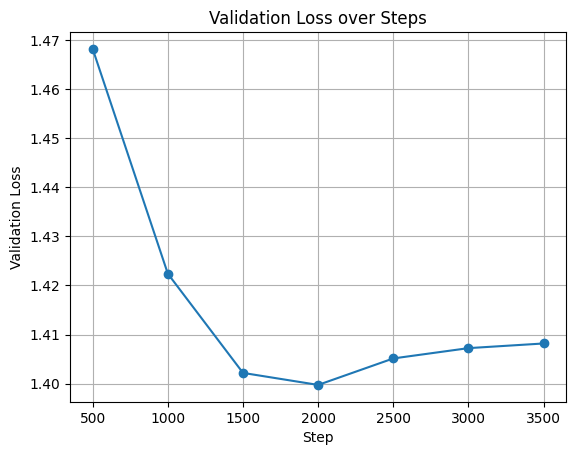

In [23]:

val_loss = []
steps = []

for log in trainer.state.log_history:
    if "eval_loss" in log.keys():
        val_loss.append(log["eval_loss"])
        steps.append(log["step"])

plt.plot(steps, val_loss, marker='o')
plt.xlabel("Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Steps")
plt.grid(True)
plt.show()


In [24]:
# predict on test data
test_results = trainer.predict(test_dataset)

preds, labels = test_results.predictions, test_results.label_ids
decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

decoded_preds = [pred.strip() for pred in decoded_preds]
decoded_labels = [label.strip() for label in decoded_labels]

bleu_test = bleu_metric.compute(
    predictions=decoded_preds,
    references=[[label] for label in decoded_labels]
)
print(f"Test BLEU score: {bleu_test['bleu']:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test BLEU score: 0.2402


In [25]:
sample_text = "Do you like to be with me?"

inputs = tokenizer(sample_text, return_tensors="pt").to(model.device)

generated_ids = model.generate(
    inputs["input_ids"],
    num_beams=4,
    max_length=50,
    early_stopping=True
)
translated = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Translated:", translated)


Translated: क्या तुम मेरे साथ होना चाहते हो?
